In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import os
import copy
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
def initialize_model(num_classes):
    input_size = 224 
    use_pretrained = True
    
    model_ft = models.resnet50(pretrained=use_pretrained)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, num_classes)
    )
    
    return model_ft, input_size

In [4]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}

    class_names = image_datasets['train'].classes
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict, class_names

In [5]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, save_all_epochs=False, num_epochs=25):
    '''
    model: The NN to train
    dataloaders: A dictionary containing at least the keys 
                 'train','val' that maps to Pytorch data loaders for the dataset
    criterion: The Loss function
    optimizer: The algorithm to update weights 
               (Variations on gradient descent)
    num_epochs: How many epochs to train for
    save_dir: Where to save the best model weights that are found, 
              as they are found. Will save to save_dir/weights_best.pt
              Using None will not write anything to disk
    save_all_epochs: Whether to save weights for ALL epochs, not just the best
                     validation error epoch. Will save to save_dir/weights_e{#}.pt
    '''
    since = time.time()
    
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)
            if phase == "train":
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))


    model.load_state_dict(best_model_wts)
    return model, train_losses, train_acc, val_losses, val_acc

In [6]:
num_classes = 5
batch_size = 16
shuffle_datasets = True
num_epochs = 100

data_dir = "/content/drive/MyDrive/Cervical Image Classification/separated-data"
save_dir = "/content/drive/MyDrive/Cervical Image Classification/weights"
os.makedirs(save_dir, exist_ok=True)

save_all_epochs = True

In [7]:
model, input_size = initialize_model(num_classes = num_classes)
model = model.to(device)
dataloaders, class_name = get_dataloaders(input_size, batch_size, shuffle_datasets)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
# Train the model!
trained_model, train_losses, train_acc, val_losses, val_acc = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, save_all_epochs=save_all_epochs, num_epochs=num_epochs)

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 1/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 1.4047 Acc: 0.4837


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 1.4654 Acc: 0.4503

Epoch 2/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 1.0849 Acc: 0.6009


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.8834 Acc: 0.6440

Epoch 3/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.9385 Acc: 0.6409


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.9104 Acc: 0.5916

Epoch 4/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.8351 Acc: 0.6884


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.6772 Acc: 0.7539

Epoch 5/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.7157 Acc: 0.7374


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.9602 Acc: 0.6963

Epoch 6/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.6676 Acc: 0.7537


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.8093 Acc: 0.7801

Epoch 7/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.7270 Acc: 0.7611


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.7421 Acc: 0.7487

Epoch 8/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.7419 Acc: 0.7255


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 1.2153 Acc: 0.7068

Epoch 9/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.5504 Acc: 0.8012


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4734 Acc: 0.8743

Epoch 10/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.5173 Acc: 0.8086


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 1.1948 Acc: 0.6806

Epoch 11/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.5554 Acc: 0.7967


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4895 Acc: 0.8534

Epoch 12/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.4770 Acc: 0.8175


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4694 Acc: 0.8115

Epoch 13/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.5588 Acc: 0.7997


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.5176 Acc: 0.7958

Epoch 14/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.5541 Acc: 0.8234


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3868 Acc: 0.9110

Epoch 15/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.5541 Acc: 0.8027


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3910 Acc: 0.8691

Epoch 16/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3365 Acc: 0.8872


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3847 Acc: 0.8691

Epoch 17/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3596 Acc: 0.8605


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.5563 Acc: 0.8168

Epoch 18/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3623 Acc: 0.8665


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.9675 Acc: 0.7120

Epoch 19/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.4077 Acc: 0.8591


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.5357 Acc: 0.8377

Epoch 20/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.4052 Acc: 0.8383


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4137 Acc: 0.8796

Epoch 21/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.4225 Acc: 0.8531


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.5125 Acc: 0.8272

Epoch 22/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3556 Acc: 0.8798


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3988 Acc: 0.8901

Epoch 23/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3453 Acc: 0.8858


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.5185 Acc: 0.8272

Epoch 24/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2883 Acc: 0.9021


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3273 Acc: 0.8901

Epoch 25/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2748 Acc: 0.9095


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4007 Acc: 0.8796

Epoch 26/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3517 Acc: 0.8754


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4181 Acc: 0.8743

Epoch 27/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3821 Acc: 0.8665


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4387 Acc: 0.8848

Epoch 28/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3280 Acc: 0.8783


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4058 Acc: 0.8953

Epoch 29/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2554 Acc: 0.9050


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4772 Acc: 0.8743

Epoch 30/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3776 Acc: 0.8798


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.2957 Acc: 0.9110

Epoch 31/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2570 Acc: 0.9199


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4544 Acc: 0.8272

Epoch 32/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3138 Acc: 0.8961


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3398 Acc: 0.8848

Epoch 33/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2205 Acc: 0.9214


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.5314 Acc: 0.8534

Epoch 34/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2302 Acc: 0.9169


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.5725 Acc: 0.8377

Epoch 35/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2274 Acc: 0.9110


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3154 Acc: 0.8796

Epoch 36/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.4252 Acc: 0.8487


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4096 Acc: 0.8639

Epoch 37/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3193 Acc: 0.8902


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.2917 Acc: 0.8901

Epoch 38/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3205 Acc: 0.8754


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3859 Acc: 0.8691

Epoch 39/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2517 Acc: 0.9095


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.2923 Acc: 0.9162

Epoch 40/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2130 Acc: 0.9273


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.2439 Acc: 0.9005

Epoch 41/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1702 Acc: 0.9421


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4655 Acc: 0.8691

Epoch 42/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2185 Acc: 0.9214


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4199 Acc: 0.9005

Epoch 43/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1655 Acc: 0.9451


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3416 Acc: 0.9005

Epoch 44/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2390 Acc: 0.9243


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4813 Acc: 0.8534

Epoch 45/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2791 Acc: 0.9080


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3620 Acc: 0.8901

Epoch 46/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2522 Acc: 0.9095


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3565 Acc: 0.8901

Epoch 47/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1659 Acc: 0.9421


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.2594 Acc: 0.9215

Epoch 48/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1947 Acc: 0.9332


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.2173 Acc: 0.9319

Epoch 49/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1981 Acc: 0.9258


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.2958 Acc: 0.9005

Epoch 50/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2288 Acc: 0.9332


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3439 Acc: 0.9110

Epoch 51/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2137 Acc: 0.9199


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4712 Acc: 0.8639

Epoch 52/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3387 Acc: 0.8976


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4753 Acc: 0.8848

Epoch 53/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2282 Acc: 0.9184


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3263 Acc: 0.9162

Epoch 54/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1636 Acc: 0.9392


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.2845 Acc: 0.9110

Epoch 55/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1871 Acc: 0.9273


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4635 Acc: 0.8534

Epoch 56/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1474 Acc: 0.9540


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.2646 Acc: 0.9058

Epoch 57/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2042 Acc: 0.9318


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4683 Acc: 0.8639

Epoch 58/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1523 Acc: 0.9347


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4281 Acc: 0.8848

Epoch 59/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1070 Acc: 0.9614


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3794 Acc: 0.8901

Epoch 60/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0914 Acc: 0.9718


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3353 Acc: 0.8901

Epoch 61/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0976 Acc: 0.9644


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.2422 Acc: 0.9424

Epoch 62/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2207 Acc: 0.9392


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3231 Acc: 0.9005

Epoch 63/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1837 Acc: 0.9318


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3798 Acc: 0.9110

Epoch 64/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1446 Acc: 0.9614


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3428 Acc: 0.9110

Epoch 65/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0646 Acc: 0.9837


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3307 Acc: 0.9267

Epoch 66/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0811 Acc: 0.9822


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4406 Acc: 0.8953

Epoch 67/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3435 Acc: 0.8843


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4487 Acc: 0.8796

Epoch 68/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2047 Acc: 0.9303


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3364 Acc: 0.9005

Epoch 69/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1876 Acc: 0.9288


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3941 Acc: 0.9005

Epoch 70/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1104 Acc: 0.9674


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.2629 Acc: 0.9424

Epoch 71/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2021 Acc: 0.9421


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3480 Acc: 0.9162

Epoch 72/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1419 Acc: 0.9481


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.2989 Acc: 0.9267

Epoch 73/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0907 Acc: 0.9733


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4705 Acc: 0.8639

Epoch 74/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1110 Acc: 0.9703


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4215 Acc: 0.8953

Epoch 75/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1165 Acc: 0.9614


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3681 Acc: 0.8901

Epoch 76/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1029 Acc: 0.9629


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4507 Acc: 0.8953

Epoch 77/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1364 Acc: 0.9496


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4373 Acc: 0.8796

Epoch 78/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1042 Acc: 0.9629


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.2944 Acc: 0.9110

Epoch 79/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1437 Acc: 0.9525


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.2546 Acc: 0.9215

Epoch 80/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0713 Acc: 0.9748


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4823 Acc: 0.8848

Epoch 81/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0508 Acc: 0.9822


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3229 Acc: 0.9215

Epoch 82/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0900 Acc: 0.9792


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.2804 Acc: 0.9162

Epoch 83/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0478 Acc: 0.9807


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.2251 Acc: 0.9267

Epoch 84/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1449 Acc: 0.9451


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3759 Acc: 0.9110

Epoch 85/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1149 Acc: 0.9659


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.2889 Acc: 0.9162

Epoch 86/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1017 Acc: 0.9644


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3849 Acc: 0.8901

Epoch 87/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1581 Acc: 0.9407


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4737 Acc: 0.8848

Epoch 88/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1041 Acc: 0.9688


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3554 Acc: 0.9058

Epoch 89/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1161 Acc: 0.9585


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.2871 Acc: 0.9319

Epoch 90/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0704 Acc: 0.9807


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3311 Acc: 0.9110

Epoch 91/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0408 Acc: 0.9896


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4576 Acc: 0.8796

Epoch 92/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0759 Acc: 0.9718


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.6231 Acc: 0.8325

Epoch 93/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1622 Acc: 0.9421


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3272 Acc: 0.8953

Epoch 94/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1856 Acc: 0.9362


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.5060 Acc: 0.8743

Epoch 95/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.4139 Acc: 0.8769


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.5305 Acc: 0.8586

Epoch 96/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1980 Acc: 0.9303


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4805 Acc: 0.8796

Epoch 97/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2796 Acc: 0.9021


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.6171 Acc: 0.7801

Epoch 98/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2019 Acc: 0.9392


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.2784 Acc: 0.9005

Epoch 99/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2183 Acc: 0.9332


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4144 Acc: 0.9005

Epoch 100/100
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1224 Acc: 0.9570


100%|██████████| 12/12 [00:45<00:00,  3.79s/it]

val Loss: 0.2972 Acc: 0.9110

Training complete in 306m 4s
Best val Acc: 0.942408


In [ ]:
# save pretrained weights
torch.save(trained_model.state_dict(), "/content/drive/MyDrive/Cervical Image Classification/weights/resnet50-100")

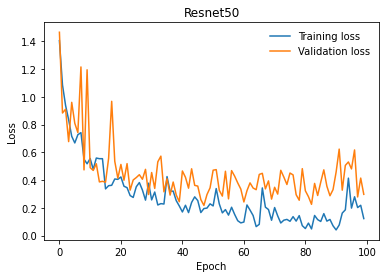

In [ ]:
x = np.arange(0,100,1)
plt.plot(x, train_losses, label='Training loss')
plt.plot(x, val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.title("Resnet50")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

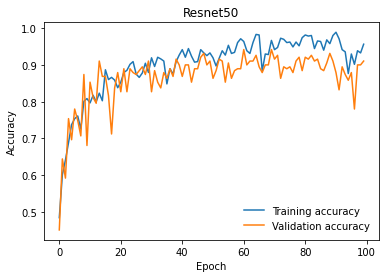

In [ ]:
plt.plot(x, train_acc, label='Training accuracy')
plt.plot(x, val_acc, label='Validation accuracy')
plt.legend(frameon=False)
plt.title("Resnet50")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
def evaluate(model, dataloader, criterion, is_labelled = False, generate_labels = True, k = 5):
    model.eval()
    running_loss = 0
    running_top1_correct = 0
    running_top5_correct = 0
    predicted_labels = []
    
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        tiled_labels = torch.stack([labels.data for i in range(k)], dim=1) 

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            if is_labelled:
                loss = criterion(outputs, labels)
            _, preds = torch.topk(outputs, k=5, dim=1)
            if generate_labels:
                nparr = preds.cpu().detach().numpy()
                predicted_labels.extend([list(nparr[i]) for i in range(len(nparr))])

        if is_labelled:
            running_loss += loss.item() * inputs.size(0)
            running_top1_correct += torch.sum(preds[:, 0] == labels.data)
            running_top5_correct += torch.sum(preds == tiled_labels)
        else:
            pass

    if is_labelled:
        epoch_loss = float(running_loss / len(dataloader.dataset))
        epoch_top1_acc = float(running_top1_correct.double() / len(dataloader.dataset))
        epoch_top5_acc = float(running_top5_correct.double() / len(dataloader.dataset))
    else:
        epoch_loss = None
        epoch_top1_acc = None
        epoch_top5_acc = None
    
    return epoch_loss, epoch_top1_acc, epoch_top5_acc, predicted_labels


In [ ]:
generate_validation_labels = True
data_dir = '/content/drive/MyDrive/Cervical Image Classification/separated-data'
dataloaders, class_name = get_dataloaders(input_size, batch_size, True)
val_loss, val_top1, val_top5, val_labels = evaluate(model, dataloaders['val'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 5)

epoch_loss, top1_acc, top5_acc, test_labels = evaluate(model, dataloaders['test'], criterion, is_labelled = True, generate_labels = True, k = 5)

100%|██████████| 7/7 [00:26<00:00,  3.83s/it]


In [ ]:
top1_acc

0.9108910891089109

# Section 5: Confusion Matrix

In [ ]:
confusion_matrix = {x: [0,0,0,0,0] for x in class_name}
running_top1_correct = 0
loader = dataloaders['test']
for inputs, labels in tqdm(loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model(inputs)
    _, preds = torch.topk(outputs, k=1, dim=1)
    for i in range(len(labels)):
        original_label = int(labels[i])
        confusion_matrix[class_name[original_label]][int(preds[i])] += 1
        
    running_top1_correct += torch.sum(preds[:, 0] == labels.data)

epoch_top1_acc = float(running_top1_correct.double() / len(loader.dataset))

100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


In [ ]:
print(confusion_matrix)


print(epoch_top1_acc)

{'im_Dyskeratotic': [23, 0, 0, 0, 0], 'im_Koilocytotic': [1, 21, 1, 1, 1], 'im_Metaplastic': [1, 0, 27, 0, 0], 'im_Parabasal': [0, 0, 0, 12, 0], 'im_Superficial-Intermediate': [0, 0, 0, 0, 13]}
0.9504950495049505


In [ ]:
percentage = {x: [y /sum(confusion_matrix[x]) for y in confusion_matrix[x]] for x in confusion_matrix.keys()}
percentage

{'im_Dyskeratotic': [1.0, 0.0, 0.0, 0.0, 0.0],
 'im_Koilocytotic': [0.04, 0.84, 0.04, 0.04, 0.04],
 'im_Metaplastic': [0.03571428571428571, 0.0, 0.9642857142857143, 0.0, 0.0],
 'im_Parabasal': [0.0, 0.0, 0.0, 1.0, 0.0],
 'im_Superficial-Intermediate': [0.0, 0.0, 0.0, 0.0, 1.0]}

In [ ]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

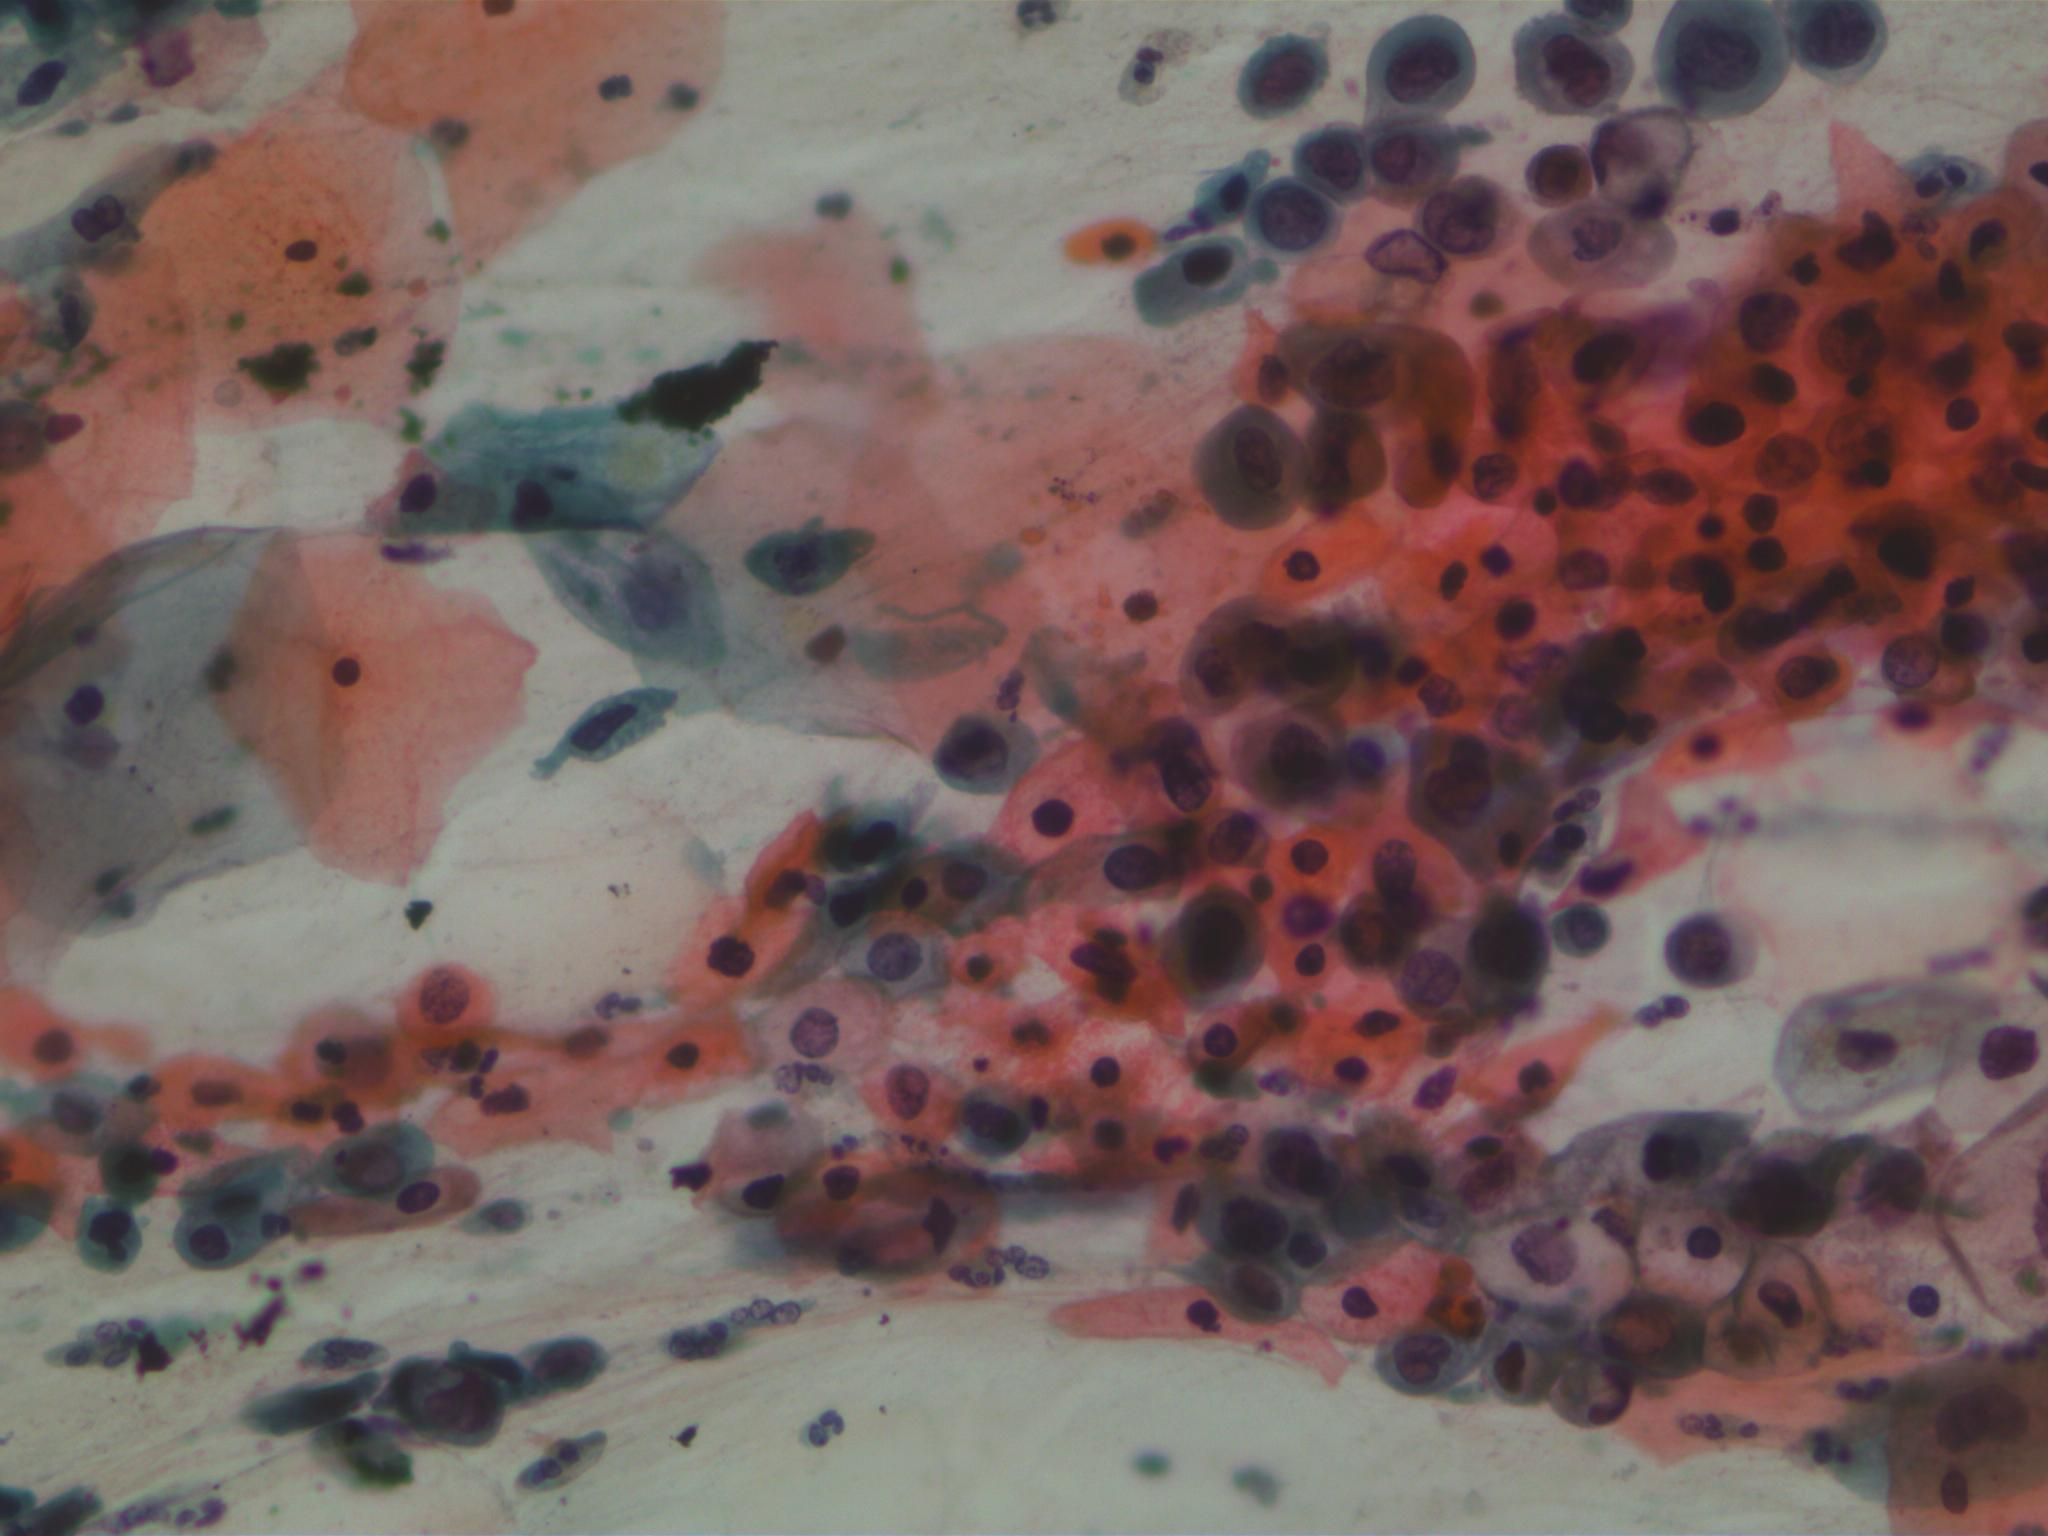

In [ ]:
img0 = PIL.Image.open('/content/drive/MyDrive/Cervical Image Classification/separated-data/train/im_Dyskeratotic/002.bmp').convert('RGB')
img_numpy = np.array(img0)
showarray(img_numpy)

In [ ]:
def test_single_image(image):
    input_size = 224
    center_crop = transforms.Compose([
         transforms.Resize((input_size)),
         transforms.CenterCrop(input_size),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    im = center_crop(image)
    im = im.to(device)
    out = model(im.unsqueeze(0)).squeeze()
    prob, categories = out.topk(5)
    sm = torch.nn.Softmax()
    probabilities = sm(prob) 
    for i in range(len(categories)):
        print(class_name[int(categories[i])] + ": " + str(float(probabilities[i])))

In [ ]:
test_single_image(img0)

im_Dyskeratotic: 0.9999929666519165
im_Koilocytotic: 5.5893915487104096e-06
im_Metaplastic: 1.100135818887793e-06
im_Parabasal: 3.367762531070184e-07
im_Superficial-Intermediate: 1.6961908544388393e-09


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.figure(figsize=(20,10))
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [ ]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)


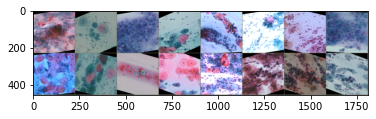

<Figure size 1440x720 with 0 Axes>

In [ ]:
imshow(out)

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    # impacts the autograd engine and deactivate it
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # iterate this batch
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, label: {}'.format(class_name[preds[j]], class_name[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

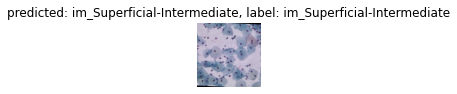

<Figure size 1440x720 with 0 Axes>

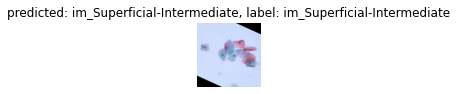

<Figure size 1440x720 with 0 Axes>

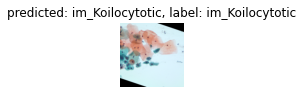

<Figure size 1440x720 with 0 Axes>

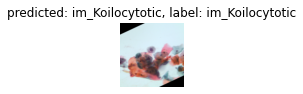

<Figure size 1440x720 with 0 Axes>

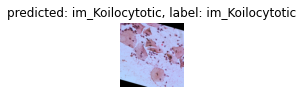

<Figure size 1440x720 with 0 Axes>

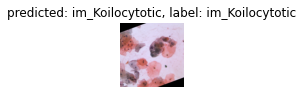

<Figure size 1440x720 with 0 Axes>

In [ ]:
visualize_model(model)

In [8]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Cervical Image Classification/weights/resnet50-100'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:

import torch
import argparse
import cv2
import numpy as np
import torch
from torch.autograd import Function
from torchvision import models, transforms

In [13]:
class FeatureExtractor():
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x

class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """

    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x)

        return target_activations, x

def preprocess_image(img):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    preprocessing = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
    return preprocessing(img.copy()).unsqueeze(0)

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input_img):
        return self.model(input_img)

    def __call__(self, input_img, target_category=None):
        if self.cuda:
            input_img = input_img.cuda()

        features, output = self.extractor(input_img)

        if target_category == None:
            target_category = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][target_category] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = one_hot.cuda()
        
        one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_img.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam


class GuidedBackpropReLU(Function):
    @staticmethod
    def forward(self, input_img):
        positive_mask = (input_img > 0).type_as(input_img)
        output = torch.addcmul(torch.zeros(input_img.size()).type_as(input_img), input_img, positive_mask)
        self.save_for_backward(input_img, output)
        return output

    @staticmethod
    def backward(self, grad_output):
        input_img, output = self.saved_tensors
        grad_input = None

        positive_mask_1 = (input_img > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(input_img.size()).type_as(input_img),
                                   torch.addcmul(torch.zeros(input_img.size()).type_as(input_img), grad_output,
                                                 positive_mask_1), positive_mask_2)
        return grad_input


class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                recursive_relu_apply(module)
                if module.__class__.__name__ == 'ReLU':
                    module_top._modules[idx] = GuidedBackpropReLU.apply

        # replace ReLU with GuidedBackpropReLU
        recursive_relu_apply(self.model)

    def forward(self, input_img):
        return self.model(input_img)

    def __call__(self, input_img, target_category=None):
        if self.cuda:
            input_img = input_img.cuda()

        input_img = input_img.requires_grad_(True)

        output = self.forward(input_img)

        if target_category == None:
            target_category = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][target_category] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = one_hot.cuda()

        one_hot = torch.sum(one_hot * output)
        one_hot.backward(retain_graph=True)

        output = input_img.grad.cpu().data.numpy()
        output = output[0, :, :, :]

        return output

def get_args():
  
    parser = argparse.ArgumentParser()
    parser.add_argument('--use-cuda', action='store_true', default=False,
                        help='Use NVIDIA GPU acceleration')
    parser.add_argument('--image-path', type=str, default='/content/drive/MyDrive/Cervical Image Classification/separated-data/test/im_Dyskeratotic/001.bmp',
                        help='Input image path')
    parser.add_argument('-f')
    args = parser.parse_args()
    args.use_cuda = args.use_cuda and torch.cuda.is_available()
    if args.use_cuda:
        print("Using GPU for acceleration")
    else:
        print("Using CPU for computation")

    return args

def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img*255)

In [14]:

args = get_args()

model = models.resnet50(pretrained=True)
grad_cam = GradCam(model=model, feature_module=model.layer4, \
                       target_layer_names=["2"], use_cuda=args.use_cuda)

img = cv2.imread(args.image_path, 1)
img = np.float32(img) / 255
# Opencv loads as BGR:
img = img[:, :, ::-1]
input_img = preprocess_image(img)

# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested category.
target_category = None
grayscale_cam = grad_cam(input_img, target_category)

grayscale_cam = cv2.resize(grayscale_cam, (img.shape[1], img.shape[0]))
cam = show_cam_on_image(img, grayscale_cam)

gb_model = GuidedBackpropReLUModel(model=model, use_cuda=args.use_cuda)
gb = gb_model(input_img, target_category=target_category)
gb = gb.transpose((1, 2, 0))

cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
cam_gb = deprocess_image(cam_mask*gb)
gb = deprocess_image(gb)

Using CPU for computation


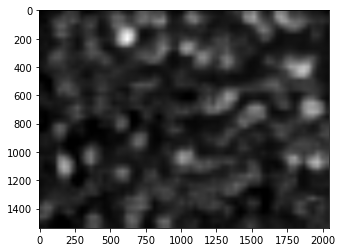

In [19]:
imgplot = plt.imshow(cam_mask)
plt.show()

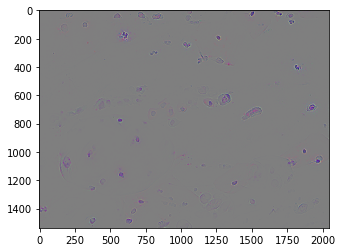

In [20]:
imgplot = plt.imshow(cam_gb)
plt.show()

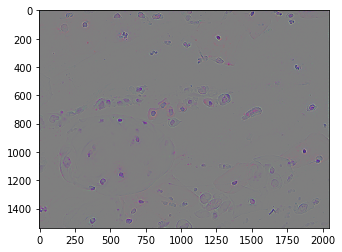

In [21]:
imgplot = plt.imshow(gb)
plt.show()